# Topic Modelling: 
Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT. 

Here I am using medium article dataset to perfom Topic Modelling. The dataset consist 350 articles related to AI, Machine Learning and Data Science.

Workflow: 
1. Import Libraries 
2. Exploring dataset 
3. Preprocessiong the data: 
    * Stopwording 
    * Cleaning 
    * Lemmitizing 
4. LDA:
    * Tokennization
    * Buildiong with gensim
    * Printing topics
5. Visualization:
    * Coherence model
6. Hyperparameter 


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Exploring the dataset :

In [2]:
import pandas as pd
medium_articles = pd.read_csv("../input/medium-articles/articles.csv")
medium_articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


Total Number of unique authors : 182


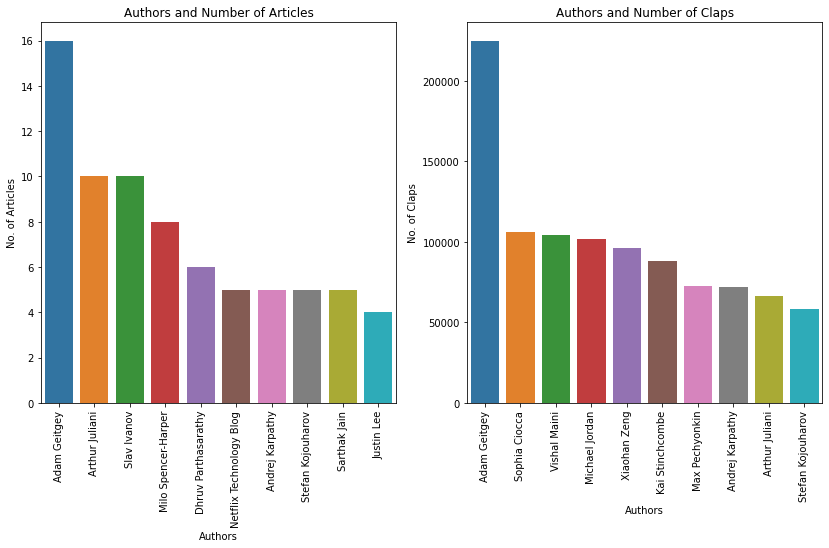

In [3]:
article_text = medium_articles.text
# visualise first article print few words from it
#print("First 1000 words in first article are : \n",article_text[0][:1000])

#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")

#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))


#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90) 



#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90) 
plt.show()

**The above graphs show that Adam Getigey has written most articles and has the highest number of claps. But when it comes to the 2nd, 3rd positions, the author's name is not the same in the graphs. It shows that either the reach of articles or the quality of articles is inadequate for the authors.**

Here, we can see that Adam Geitgey has written highest number of articles.

## Preprocessing Text Data

In [4]:
#lowercase the articles 
medium_articles.text = medium_articles.text.apply(lambda t : t.lower())

**Expanding contractions:** Contractions are the shortened form of the words like it's, hasn't. We expand them for better analysis of our text data. I have taken these contractions from [Analytics Vidhay's article](http://https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/).

In [5]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
medium_articles.text = medium_articles.text.apply(lambda x:expand_contractions(x))

**Removing Stopwords and Puctuations**: Stopwords are the words that are highly occurred in a language; they do not add any significance to the sentence. "a," "an," "the," "in" are some examples of stopwords. So we generally ignore stop words during our NLP task. In some NLP tasks, stop words are also important, but stopwords are unnecessary for topic modeling. We also remove punctuation marks because they are also unnecessary and do not contribute anything.

In [6]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**In-Depth Data Observation and Cleaning: There are still data needed to be cleansed as we have observed in the results previously that there are signs and punctuations, other logical operators signs and etc.**

In [7]:
print(f"These are the pucntions which string.punctuation consist :  {string.punctuation}")

These are the pucntions which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the article after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
medium_articles.text = medium_articles.text.apply(remove_stopwords)

#removing Punctuations 
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing digits
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('\w*\d\w*','', x))

medium_articles.text[50]

'upd  april      scikit flow merged tensorflow since version  called tensorflow learn tflearn  google released machine learning framework called tensorflow ’ taking world storm   stars github  lot publicity general excitement ai researchers   use something regular problem data scientist may   ai researcher — build interesting problems time   reasonable question  data scientist  already number tools toolbox  r  scikit learn  etc   care yet another framework  answer two part  let ’ start simple example — take titanic dataset kaggle  first  make sure installed tensorflow scikit learn helpful libs  including scikit flow simplifying lot work tensorflow  get dataset code http  githubcomilblackdragontfexamples quick look data  use ipython ipython notebook ease interactive exploration   let ’ test predict survived class  based float variables scikit learn  separate dataset features target  fill na data zeros build logistic regression  predicting training data gives us measure accuracy  cause ’

**There are still some marks like quotation marks, hypen and apostrophe still remaining in the article, we also need to remove them.**

In [9]:
def remove_extra_marks(article):
    extra_keys = ["’","—","”","“"]
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in extra_keys] 
    return " ".join(filtered_article)
    
medium_articles.text = medium_articles.text.apply(remove_extra_marks)

In [10]:
#printing arbitrary example to visulise clean data
medium_articles.text[50]

'upd april scikit flow merged tensorflow since version called tensorflow learn tflearn google released machine learning framework called tensorflow taking world storm stars github lot publicity general excitement ai researchers use something regular problem data scientist may ai researcher build interesting problems time reasonable question data scientist already number tools toolbox r scikit learn etc care yet another framework answer two part let start simple example take titanic dataset kaggle first make sure installed tensorflow scikit learn helpful libs including scikit flow simplifying lot work tensorflow get dataset code http githubcomilblackdragontfexamples quick look data use ipython ipython notebook ease interactive exploration let test predict survived class based float variables scikit learn separate dataset features target fill na data zeros build logistic regression predicting training data gives us measure accuracy cause properly evaluate model quality test dataset used 

**Lemmaztisation:** Lemmatization process Topic modeling algorithm to avoid making mistakes by converting the word in its root from like lemmatization prevents counting "help", "helps", "helping" as three different words. Stemming can also be used, but it performs the task more forcefully, and sometimes the word loses its meaning, so I prefer lemmatization for the topic modeling task.

Here I am using **spacy** library to perform the lemmatizaton task.

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')
print(f""" "helps" after lemmztization :  {nlp("helps")[0].lemma_}""")
print(f""" "helping" after lemmztization :  {nlp("helping")[0].lemma_}""")

 "helps" after lemmztization :  help
 "helping" after lemmztization :  help


In [12]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
medium_articles.text = medium_articles.text.apply(lemmatize)

Now we have finished with all the data preprocessing steps, and let's plot a word cloud to visualize the most frequently used words and see the most commonly occurred word in the articles.

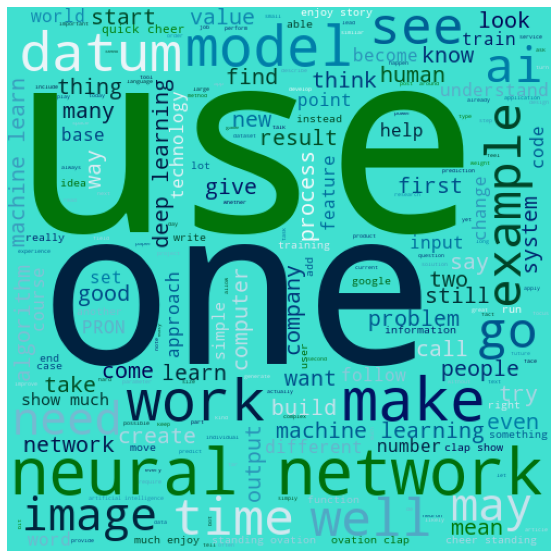

In [13]:
import wordcloud
from wordcloud import WordCloud

#combine all the articles
article_data = ""
for article in medium_articles.text:
    article_data = article_data+" "+article

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Latent Dirichlet Allocation[LDA]:  

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically. <br> 

Before I start my research and also in the beginning of my data scientist career, I loved to watch this one video clearly explained LDA in the most simplest and easiest way. Here i would liek to provide the link for you: 

Enjoy! 

https://youtu.be/3mHy4OSyRf0?si=LT43HBdd7xLfZFDz


> Now lets talk a bit about the algorithm and how it works! <br>

LDA algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

Now let's understand the work methodology of LDA using Plate Diagram:
<br>


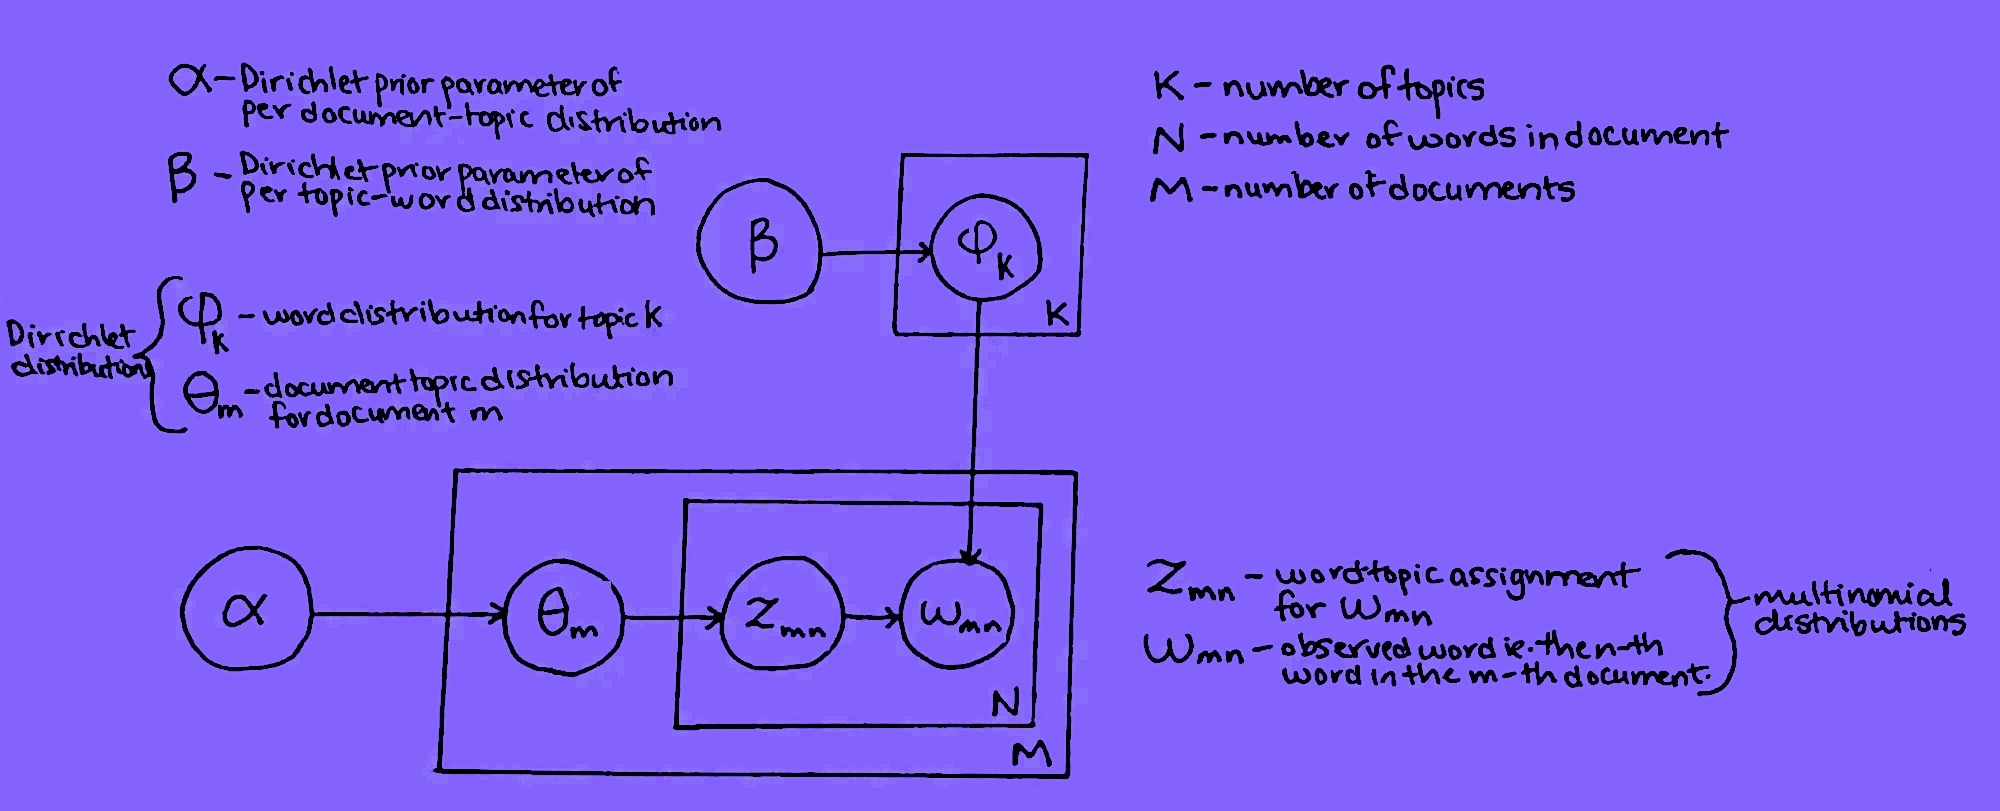](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*yHnDOAR2LBJJ6hHws00vWg.jpeg)

I got this clearly written description and the picture from teh link below: 

Check this one here!

https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8



Here, $\alpha$ and $\beta$ are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution($\alpha$) and per topic word distribution($\beta$), respectively. And **Z** is the topic for the **N**-th word in document **M**, and **W** is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

$\theta$ is the matrix where rows are the documents; columns are topics, and $\theta(i,j)$ represents the probability of $ith$ document containing $jth$ topic. Similarly, $\phi$ is the matrix where rows are the topics; columns are words, and $\phi(i,j)$ represents the probability of $ith$ topic containing $jth$ word. According to the distribution of $\phi$; **K** individual words are generated for the topics.(http://)

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

In [14]:
#tokenize articles
tokeize_article = medium_articles.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[("'", 8),
 ('-PRON-', 3),
 ('able', 1),
 ('abruptly', 1),
 ('acceptance', 1),
 ('access', 1),
 ('accident', 1),
 ('accord', 2),
 ('achieve', 2),
 ('adage', 1),
 ('advantage', 1),
 ('agenda', 1),
 ('ageold', 1),
 ('ago', 2),
 ('ai', 3),
 ('aim', 1),
 ('alive', 1),
 ('allow', 1),
 ('allrounder', 1),
 ('along', 1),
 ('also', 1),
 ('alternative', 1),
 ('amount', 1),
 ('analyze', 1),
 ('another', 5),
 ('answer', 1),
 ('anticipate', 1),
 ('anticlimax', 1),
 ('anyone', 1),
 ('anything', 2),
 ('app', 12),
 ('applied', 1),
 ('approach', 3),
 ('arcane', 2),
 ('area', 2),
 ('arise', 1),
 ('around', 3),
 ('asay', 1),
 ('ask', 1),
 ('aspect', 1),
 ('assumption', 1),
 ('attention', 1),
 ('automate', 2),
 ('available', 1),
 ('average', 1),
 ('away', 2),
 ('back', 3),
 ('baffle', 1),
 ('basic', 1),
 ('basically', 1)]

In [15]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"cluster" + 0.004*"watson" + 0.003*"recipe" + 0.003*"market" + '
  '0.002*"ksr" + 0.002*"sp" + 0.002*"ingredient" + 0.001*"vector" + '
  '0.001*"sausage" + 0.001*"table"'),
 (1,
  '0.016*"network" + 0.013*"use" + 0.011*"neural" + 0.008*"learn" + '
  '0.008*"one" + 0.007*"model" + 0.007*"learning" + 0.007*"layer" + '
  '0.006*"function" + 0.006*"datum"'),
 (2,
  '0.016*"de" + 0.008*"en" + 0.006*"para" + 0.006*"que" + 0.005*"la" + '
  '0.005*"el" + 0.004*"como" + 0.004*"es" + 0.004*"con" + 0.004*"palabras"'),
 (3,
  '0.007*"ai" + 0.005*"machine" + 0.005*"use" + 0.005*"like" + 0.005*"people" '
  '+ 0.005*"human" + 0.005*"make" + 0.004*"one" + 0.004*"system" + '
  '0.004*"intelligence"'),
 (4,
  '0.004*"jane" + 0.003*"augusta" + 0.003*"brian" + 0.003*"→" + 0.002*"duplex" '
  '+ 0.002*"crystal" + 0.002*"rex" + 0.001*"carla" + 0.001*"aunt" + '
  '0.001*"dr"'),
 (5,
  '0.010*"de" + 0.006*"la" + 0.006*"man" + 0.005*"woman" + 0.004*"attract" + '
  '0.004*"l" + 0.004*"et" + 0.004*"

We can interpret this output as for topic 0, word, vector,ai, make, cluster, go, system, use, one are 10 most important keywords. The weight of "ai" on topic 0 is 0.008.

### Visualising Topics:

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.292135 -0.006749       1        1  46.428600
3      0.163837  0.031798       2        1  33.328209
9      0.077339 -0.136714       3        1   6.376643
6      0.033659  0.135995       4        1   4.575279
8     -0.045887 -0.001613       5        1   3.128712
5     -0.089247  0.003002       6        1   2.742279
7     -0.082050 -0.005218       7        1   1.298422
0     -0.105450 -0.003503       8        1   0.839731
2     -0.132517 -0.012231       9        1   0.655758
4     -0.111818 -0.004768      10        1   0.626367, topic_info=           Term         Freq        Total Category  logprob  loglift
1429      image  1130.000000  1130.000000  Default  30.0000  30.0000
362     machine  1321.000000  1321.000000  Default  29.0000  29.0000
782    learning  1368.000000  1368.000000  Default  28.0000  28.0000
1040     neural  1740.000000  1740.000000  Default  27.0000  27.0000
1039    network  2690.000000  2690.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
12847  samantha     1.181719    15.541713  Topic10  -7.4804   2.4964
1191        eye     1.573869    62.006861  Topic10  -7.1938   1.3993
5140      woman     1.567254    72.066615  Topic10  -7.1981   1.2447
327         kid     1.051196    28.290530  Topic10  -7.5974   1.7804
521         say     0.931676   639.090052  Topic10  -7.7181  -1.4578

[604 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.501566  -PRON-
1         2  0.460432  -PRON-
1         3  0.021230  -PRON-
1         4  0.005308  -PRON-
1         6  0.009288  -PRON-
...     ...       ...     ...
3137      3  0.114046       –
3137      4  0.252102       –
676       1  0.705720       →
676       2  0.121676       →
676      10  0.121676       →

[1817 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 10, 7, 9, 6, 8, 1, 3, 5])

To measure how good is our model we can use **perplexity score** and **coherence socre**. The lower score of perplexity is better for the model.

In [18]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.817936732960423

Coherence Score:  0.4259008229396278


This notebook is mainly focused on LDA implementation for coherence score you can read this [medium article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

### Tuning hyperparameters:

We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [ ]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 2 ; alpha : symmetric ; beta : auto ; Score : 0.33291395874303764


The highest coherence score is : 0.4962 for number of topics = 14  alpha = 0.3 and beta = auto

Final LDA Model :

In [ ]:
n = 14
alpha = 0.3
beta = "auto"
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis